# Ensemble Q learning implementation
In the following we show how to implement an agent in Colosseum with an ensemble version of Q-learning.


In [1]:
import os
import re
from typing import Union, Dict, Any, Callable

import dm_env
import gin
import numpy as np
from ray import tune

from colosseum import config
from colosseum.benchmark import ColosseumBenchmarks
from colosseum.benchmark.analysis.plots import agent_performances_per_mdp_plot, \
    plot_labels_on_benchmarks_hardness_space, get_index
from colosseum.benchmark.analysis.tables import get_latex_table_of_average_indicator
from colosseum.benchmark.run import run_benchmark
from colosseum.dynamic_programming.utils import get_policy_from_q_values
from colosseum.agent.actors import QValuesActor
from colosseum.agent.agents.episodic import QLearningEpisodic
from colosseum.agent.mdp_models.base import BaseMDPModel
from colosseum.agent.agents.base import BaseAgent
from colosseum.utils.acme.specs import MDPSpec
from colosseum.experiment.hyperopt.base import SMALL_HYPERPARAMETERS_OPTIMIZATION_CONFIGURATION

/home/michelangelo/miniconda3/envs/test37/lib/python3.7/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/michelangelo/miniconda3/envs/test37/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


We first define an MDPModel. In colosseum, the BaseMDPModel class provides a way to create a model of the environment. Note that the term model is used loosely here and it can refer to a model of the transition dynamics of the MDP as well as a Q values table.

For our Ensemble Q-learning agent, we define QEnsembleModel that inherits from BaseMDPModel and implements:
- step_update: is the function that is called at every step the agent takes in the environment and provides a way to store transition data and/or to perform updates of the model.
- active_Q: is a property that returns the q-values corresponding to the active head.

In [2]:
class QEnsembleModel(BaseMDPModel):
    def __init__(
        self,
        seed: int,
        environment_spec: "MDPSpec",
        n_ensembles: int,
        alpha: float,
    ):
        super(QEnsembleModel, self).__init__(seed, environment_spec)

        self._alpha = alpha
        self.active_head = 0

        self.Q = self._rng.randn(self._H, self._n_states, self._n_actions, n_ensembles)
        self.V = np.zeros((self._H + 1, self._n_states), np.float32)

    @property
    def active_Q(self):
        return self.Q[..., self.active_head]

    def step_update(
        self, ts_t: dm_env.TimeStep, a_t: "ACTION_TYPE", ts_tp1: dm_env.TimeStep, h: int
    ):
        s_t = ts_t.observation
        s_tp1 = ts_tp1.observation

        # Just a very simple q-learning update
        self.Q[h, s_t, a_t] = self._alpha * self.Q[h, s_t, a_t] + (1 - self._alpha) * (
            ts_tp1.reward + self.V[h + 1, s_tp1]
        )
        self.V[h, s_t] = min(self._H, self.Q[h, s_t].max())

We now can proceed to implement the class for the Ensemble Q-learning agent which inherits from BaseAgent class. Note that it is important to add the @gin.configurable decorator to the class. This allows us to run the Colosseum benchmark for the agent class.

The `is_episodic` function is a simple way to check whether the class is suited for the episodic setting.

In the `__init__` function, we need to define two important objects, an MDP model and an actor. These two objects are then passed to the super call and represent the fundamental pillars that enable the agent/MDP interaction.
The MDP model is an instance of the previously defined QEnsembleModel class whereas the actor is an instance of the QValuesActor, which is an actor class available in Colosseum and encodes a q values based policy.

The `episode_end_update` is called when the episode ends and, in our case, we use it to sample a new active head for the QEnsembleModel and to set the q values corresponding to the newly sampled head in the QValuesActor class.

The `before_start_interacting` is called before the agent starts to interact with the MDP and, in our case, we just call the previously defined `episode_end_update` that sets up the QValuesActor.

The `current_optimal_stochastic_policy` property returns the policy that, given the agent's current knowledge, would act optimally in the MDP. In our case, we simply return the policy derived from the average q values over the ensembles.

The `get_hyperparameters_search_spaces`, `produce_gin_file_from_hyperparameters` and `get_agent_instance_from_hyperparameters` functions are in charge of handling the hyperparameters and are used in the hyperparameters optimization procedure.


In [3]:
@gin.configurable
class EnsembleQLearning(BaseAgent):
    @staticmethod
    def is_episodic() -> bool:
        return True

    def __init__(
        self,
        # Base parameters
        seed: int,
        environment_spec: "MDPSpec",
        optimization_horizon: int,
        # MDP model hyperparameters
        n_ensembles: int,
        alpha: float,
        # Actor hyperparameters
        epsilon_greedy: Union[float, Callable] = None,
        boltzmann_temperature: Union[float, Callable] = None,
    ):
        assert 0 < alpha < 1
        assert n_ensembles > 0

        self._n_ensembles = n_ensembles

        mdp_model = QEnsembleModel(seed, environment_spec, n_ensembles, alpha)
        actor = QValuesActor(
            seed, environment_spec, epsilon_greedy, boltzmann_temperature
        )

        super(EnsembleQLearning, self).__init__(
            seed, environment_spec, mdp_model, actor, optimization_horizon
        )

    def episode_end_update(self):
        self._mdp_model.active_head = self._rng_fast.randint(0, self._n_ensembles - 1)
        self._actor.set_q_values(self._mdp_model.active_Q)

    def before_start_interacting(self):
        self.episode_end_update()

    @property
    def current_optimal_stochastic_policy(self) -> np.ndarray:
        Q_average = self._mdp_model.Q.mean(-1)
        return get_policy_from_q_values(Q_average, True)

    @staticmethod
    def get_hyperparameters_search_spaces() -> Dict[str, tune.sample.Domain]:
        return {
            "n_ensembles": tune.randint(3, 20),
            "alpha": tune.uniform(0.001, 0.4),
        }

    @staticmethod
    def produce_gin_file_from_hyperparameters(
        hyperparameters: Dict[str, Any], index: int = 0
    ):
        string = ""
        for k, v in hyperparameters.items():
            string += f"prms_{index}/EnsembleQLearning.{k} = {v}\n"
        return string[:-1]

    @staticmethod
    def get_agent_instance_from_hyperparameters(
        seed: int,
        optimization_horizon: int,
        mdp_specs: MDPSpec,
        hyperparameters: Dict[str, Any],
    ) -> "BaseAgent":
        return EnsembleQLearning(
            environment_spec=mdp_specs,
            seed=seed,
            optimization_horizon=optimization_horizon,
            alpha=hyperparameters["alpha"],
            n_ensembles=hyperparameters["n_ensembles"],
        )

We can now proceed to test our implementation using the MDPLoop class and double check that it is able to solve a simple MDP.

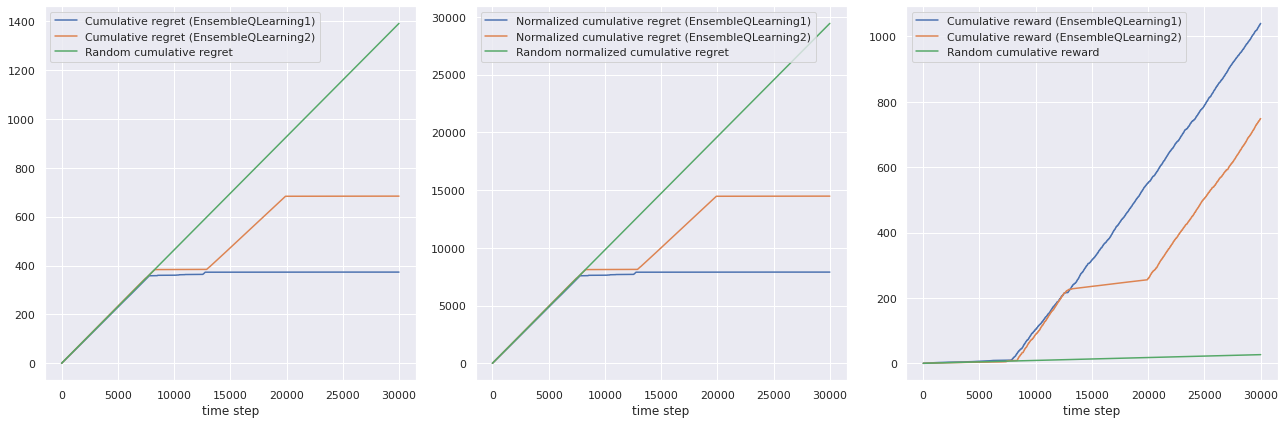

In [4]:
from colosseum.utils import make_environment_spec
from matplotlib import pyplot as plt, cm
from colosseum.utils.acme import InMemoryLogger
from colosseum.mdp.river_swim import RiverSwimEpisodic
from colosseum.experiment.agent_mdp_interaction import MDPLoop

optimization_horizon = 30_000

mdp = RiverSwimEpisodic(
    seed=0,
    p_rand=0.05,
    size=15,
)

agent = EnsembleQLearning(
    seed=42,
    environment_spec=make_environment_spec(mdp),
    optimization_horizon=optimization_horizon,
    n_ensembles=30,
    alpha=0.2,
)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 6, 6))

loop = MDPLoop(
    mdp, agent, logger=InMemoryLogger()
)  # or CSVLogger() to save the logs in csv files.
loop.run(T=optimization_horizon, log_every=10)
loop.plot(["cumulative_regret"], ax1, common_label="EnsembleQLearning1")
loop.plot(["normalized_cumulative_regret"], ax2, common_label="EnsembleQLearning1")
loop.plot(["cumulative_reward"], ax3, common_label="EnsembleQLearning1")

agent = EnsembleQLearning(
    seed=42,
    environment_spec=make_environment_spec(mdp),
    optimization_horizon=optimization_horizon,
    n_ensembles=5,
    alpha=0.2,
)
loop = MDPLoop(
    mdp, agent, logger=InMemoryLogger()
)  # or CSVLogger() to save the logs in csv files.
loop.run(T=optimization_horizon, log_every=10)
loop.plot(
    ["cumulative_regret", "random_cumulative_regret"],
    ax1,
    common_label="EnsembleQLearning2",
)
loop.plot(
    ["normalized_cumulative_regret", "random_normalized_cumulative_regret"],
    ax2,
    common_label="EnsembleQLearning2",
)
loop.plot(
    ["cumulative_reward", "random_cumulative_reward"],
    ax3,
    common_label="EnsembleQLearning2",
)


plt.tight_layout()
plt.show()

We can also proceed to run the agent on the Colosseum benchmark. For the sake of the tutorial, we will use the quick test configuration of the benchmark. Notet that you can change to code below to run the agent on the entire benchmark by setting `benchmark_to_run=ColosseumBenchmarks.ALL`.

In [5]:

# We need to register the EnsembleQLearning since it is not implemented in the Colosseum package
config.register_agent_class(EnsembleQLearning)

# We set up the folder to run the experiments and to store the results
config.set_experiment_to_run_folder("tutorial_agent_run")
config.set_experiment_results_folder("tutorial_agent_results")

# We can either use some pre-defined parameter
# hyperparams = EnsembleQLearning.produce_gin_file_from_hyperparameters(
#     dict(n_ensembles=10, alpha=0.2)
# )
# or let Colosseum run the hyperparameters optimization procedure with the SMALL_HYPERPARAMETERS_OPTIMIZATION_CONFIGURATION
hyperparams = None

run_benchmark(
    agent_classes_to_benchmark_with_hyperparameters={
        EnsembleQLearning: hyperparams,
        QLearningEpisodic: None,  # we use the default config from Colosseum
    },
    load_colosseum_cached_hyperparams=True,
    n_cores=1,
    benchmark_to_run=ColosseumBenchmarks.EPISODIC_QUICK_TEST,
    hpoc=SMALL_HYPERPARAMETERS_OPTIMIZATION_CONFIGURATION,
)

Random search started for EnsembleQLearning.
 0:00:22 time left with 3 completed measures.Search took 0:02:45 and computed 4 full agent/MDP interactions.
The best hyperparameters are: {'n_ensembles': 15, 'alpha': 0.238} with a total regret of 0.62215
The worst hyperparameters obtained 0.62733 regret and the average over all the regrets is 0.62604 plus minus 0.00224.
Retrieving experiments:
	- benchmark_episodic_quick_test


100%|██████████| 28/28 [04:00<00:00,  8.58s/it]


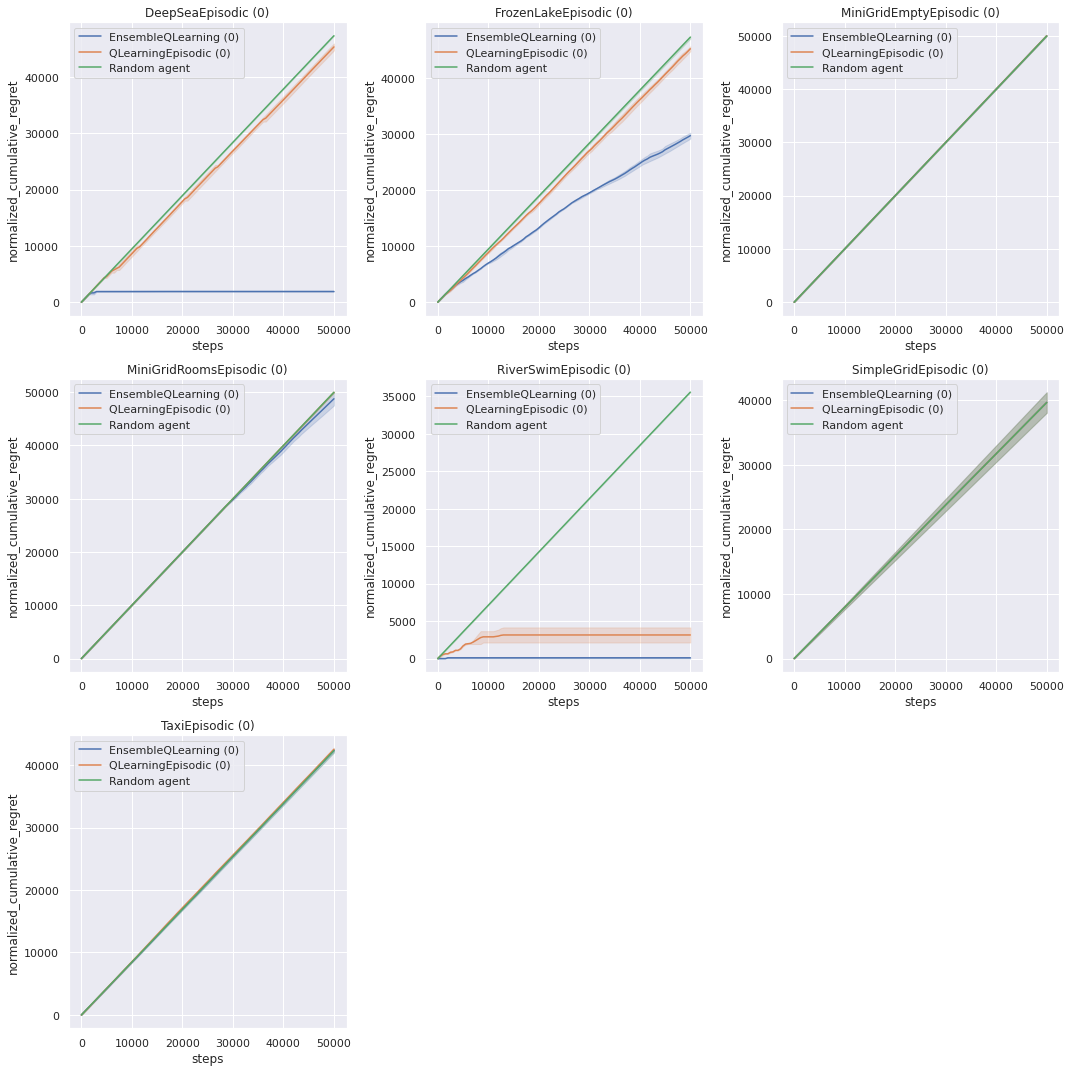

In [6]:
experiment_result_folder_path = (
    f"tutorial_agent_results{os.sep}{os.listdir('tutorial_agent_results')[0]}"
)

agent_performances_per_mdp_plot(
    experiment_result_folder_path,
    "normalized_cumulative_regret",
    figsize_scale=5,
    save_plot_to_file=False,
)

<>:13: DeprecationWarning: invalid escape sequence \d
benchmark_episodic_quick_test: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


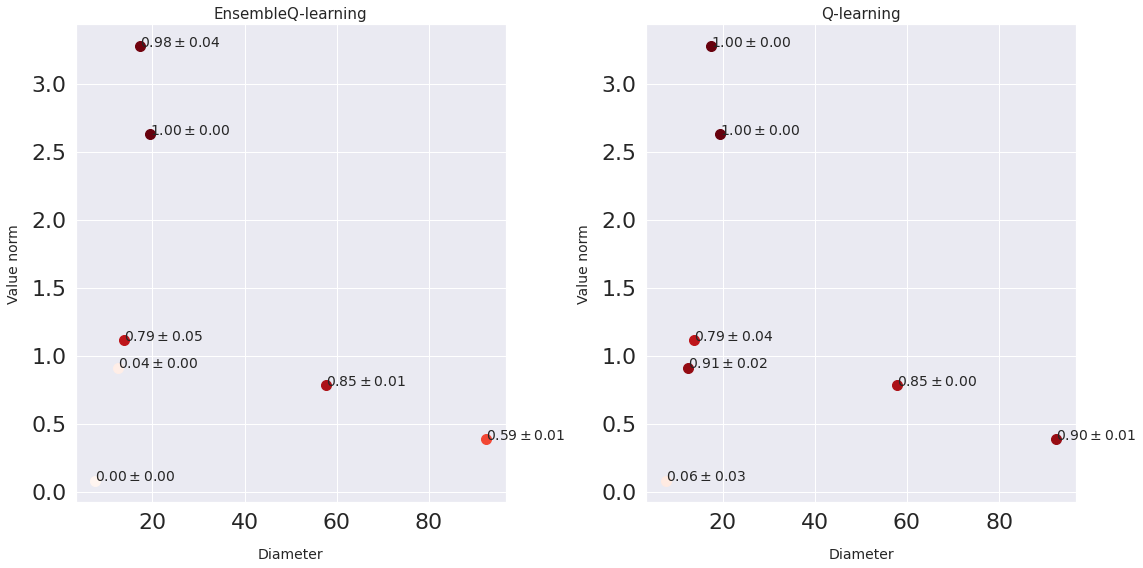

In [7]:
experiment_result_folder_path = (
    f"tutorial_agent_results{os.sep}{os.listdir('tutorial_agent_results')[0]}"
)

color_map = cm.get_cmap("Reds")
_, df = get_latex_table_of_average_indicator(
    experiment_result_folder_path,
    "normalized_cumulative_regret",
    show_prm=True,
    return_table=True,
    mdps_on_row=False,
)
df_numerical = df.applymap(lambda s: float(re.findall("\d+\.\d+", s)[0]))

fig, axes = plt.subplots(1, len(df.index), figsize=(len(df.index) * 8, 8))
for a, ax in zip(df.index, axes.tolist()):
    plot_labels_on_benchmarks_hardness_space(
        experiment_result_folder_path,
        label_f=lambda x: None,
        color_f=lambda x: color_map(
            df_numerical.loc[a, get_index(x)] / df_numerical.loc[a].max()
        ),
        text_f=lambda x: df.loc[a, get_index(x)],
        ax=ax,
        fontsize=14,
    )
    ax.set_title(a[0], fontdict=dict(fontsize=15))
plt.tight_layout()
plt.show()